In [71]:
'''austinrochford.com'''

'austinrochford.com'

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np 
import pymc3 as pm
from pymc3.distributions.timeseries import GaussianRandomWalk
import seaborn as sns

In [2]:
from theano import tensor as T

In [4]:
from statsmodels import datasets

In [6]:
df = datasets.get_rdataset('mastectomy', 'HSAUR', cache = True).data


In [7]:
df.head()


,time,event,metastized
0,23,True,no
1,47,True,no
2,69,True,no
3,70,False,no
4,100,False,no


In [10]:
df.event = df.event.astype(np.int64)
df.metastized = (df.metastized == 'yes').astype(np.int64)
n_patients = df.shape[0]

In [11]:
df.head()

,time,event,metastized
0,23,1,0
1,47,1,0
2,69,1,0
3,70,0,0
4,100,0,0


Interested in looking at S(t) = P(T > t) = 1 - F(t)
Where T is the time to the event we are looking for.

S(t) is the probability of the observed unit surviving at least as long as t

Makes life easy to use the hazard rate $$\lambda(t)$$, the instantaneous probability of dying at t conditioned on being alive.

$$ \lambda(t) = \lim_{\Delta t -> 0} \frac{ P(t < T < t + \Delta t | T > t)}{\Delta t} $$

$$ \lambda(t) = \lim_{\Delta t -> 0} \frac{ P(t < T < t + \Delta t)}{\Delta t * P(T > t) } $$

$$ \lambda(t) = \frac {1}{S(t)} * \lim_{\Delta t -> 0} \frac{ S(t + \Delta t) - S(t) }{\Delta t} $$

$$ \lambda(t) = - \frac {S'(t)}{S(t)} $$

$$S(t) = exp(-\int_{0} ^ {s}\lambda (s)  d(s))$$

Shows the link between the survival function and the cumulative hazard function:
    
$$ \Lambda (t) = \int_{0}^{t} \lambda (s) ds$$

$$ S(t) = exp( - \Lambda (t) )$$

In [15]:
patients = np.arange(n_patients)

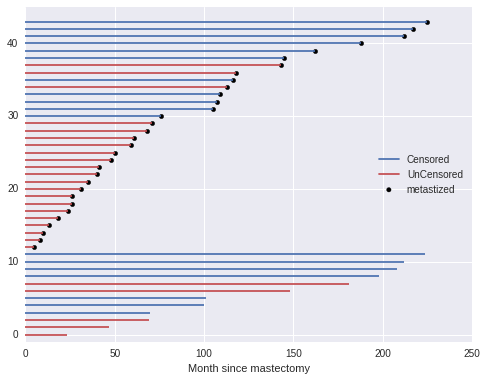

In [26]:
fig, ax = plt.subplots(figsize = (8, 6))
blue, _, red = sns.color_palette()[:3]

ax.hlines(patients[df.event.values == 0], 0, df[df.event.values == 0].time, color = blue, label = "Censored")
ax.hlines(patients[df.event.values == 1], 0, df[df.event.values == 1].time, color = red, label = "UnCensored")

plt.scatter(df[df.metastized.values == 1].time, patients[df.metastized.values == 1], color = "black", label = "metastized")
plt.xlim(0, 250)
plt.ylim(-1, 45)
plt.xlabel("Month since mastectomy")
plt.legend(loc = "center right")

When df.event is zero (event is censored), the df.time is not survival time, all we know is that the amount is greater than the observed t

Two commonly used estimators - Kaplan-Meier estimator of the survival function and the Nelson-Aalen estimator of the cumulative hazard function (see link between the two above)

Alternatvie - risk regression model - e.g. Cox's proportional hazards model

$$ \lambda (t) = \lambda _0 (t) exp(x \beta) $$

lambda_0 is the baseline hazard which is indep of the covariates (think the intercept term)

If we're studying the effect of metastiziation then the covariant is the one dimensional vector df.metastized.  No constant term as would make unindentifiable due to lambda_0

Need to make priors for l_0 and beta, with meta terms for the means and variances

Prior for l_0 isn't obvious.  One solution is to create a stepwise prior.  Bucket periods of time into intervals then choose priors for the N - 1 values lambda_j

In [27]:
interval_length = 3
interval_bounds = np.arange(0, df.time.max() + interval_length + 1, interval_length)

In [28]:
n_intervals = interval_bounds.size - 1

In [29]:
intervals = np.arange(n_intervals)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  2.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  1.,  0.,  0.,  1.,  2.,  0.,  1.,  0.,  1.,  1.]),
 array([  0,   3,   6,   9,  12,  15,  18,  21,  24,  27,  30,  33,  36,
         39,  42,  45,  48,  51,  54,  57,  60,  63,  66,  69,  72,  75,
         78,  81,  84,  87,  90,  93,  96,  99, 102, 105, 108, 111, 114,
        117, 120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150, 153,
        156, 159, 162, 165, 168, 171, 174, 177, 180, 183, 186, 189, 192,
        195, 198, 201, 204, 207, 210, 213, 216, 219, 222, 225, 228], dtype=int64),
 <a list of 76 Patch objects>)

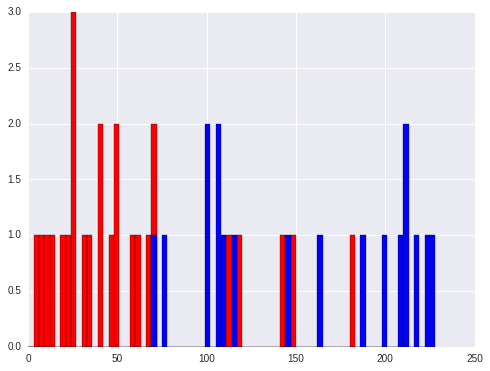

In [30]:
fig, ax = plt.subplots(figsize = (8,6))

ax.hist(df[df.event == 1].time.values, bins = interval_bounds, color = "r", label = "Uncensored")
ax.hist(df[df.event == 0].time.values, bins = interval_bounds, color = "blue", label = "Uncensored")

In [31]:
last_period = np.floor( (df.time - 0.01) / interval_length)

In [32]:
death = np.zeros((n_patients, n_intervals))

In [51]:
death[2,]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [34]:
death[patients, last_period] = df.event

/home/jakecoltman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
  if __name__ == '__main__':


In [35]:
death

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [36]:
exposure = np.greater_equal.outer(df.time, interval_bounds[:-1]) * interval_length
exposure[patients, last_period] = df.time - interval_bounds[last_period]

/home/jakecoltman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
  from ipykernel import kernelapp as app


In [37]:
exposure

array([[3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       ..., 
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 3, 3, 3]])

In [52]:
exposure[1,]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

$$ \lambda _{i,j} = \lambda _j exp(x _i \beta) $$

In [46]:
death[death[:]!= 0]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [66]:
with pm.Model() as model:
    lambda0 = pm.Gamma('lambda0', 0.01, 0.01, shape = n_intervals)
    
    sigma = pm.Uniform('sigma', 0., 10.)
    tau = pm.Deterministic('tau', sigma ** 2)
    mu_beta = pm.Normal('mu_beta', 0., 10 ** - 2)
    beta = pm.Normal('beta', mu_beta, tau)
    
    lambda_ = pm.Deterministic('lambda_', T.outer(T.exp(beta * df.metastized), lambda0))
    mu = pm.Deterministic('mu', exposure * lambda_)
    
    obs = pm.Poisson('obs', mu, observed = death)

Applied log-transform to lambda0 and added transformed lambda0_log to model.
Applied interval-transform to sigma and added transformed sigma_interval to model.


In [67]:
n_samples = 4000
burn = 2000
thin = 20

In [68]:
with model:
    step = pm.Metropolis()
    trace_ = pm.sample(n_samples)

ERROR (theano.gof.opt): SeqOptimizer apply <theano.tensor.opt.FusionOptimizer object at 0xae56788c>
ERROR:theano.gof.opt:SeqOptimizer apply <theano.tensor.opt.FusionOptimizer object at 0xae56788c>
ERROR (theano.gof.opt): Traceback:
ERROR:theano.gof.opt:Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/jakecoltman/anaconda3/lib/python3.5/site-packages/Theano-0.7.0-py3.5.egg/theano/gof/opt.py", line 196, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/jakecoltman/anaconda3/lib/python3.5/site-packages/Theano-0.7.0-py3.5.egg/theano/gof/opt.py", line 82, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/home/jakecoltman/anaconda3/lib/python3.5/site-packages/Theano-0.7.0-py3.5.egg/theano/tensor/opt.py", line 5499, in apply
    new_outputs = self.optimizer(node)
  File "/home/jakecoltman/anaconda3/lib/python3.5/site-packages/Theano-0.7.0-py3.5.egg/theano/tensor/opt.py", line 5434, in local_fuse
    n = OP(C)(*inputs).owner
  

Assigned NUTS to lambda0_log
Assigned NUTS to sigma_interval
Assigned NUTS to mu_beta
Assigned NUTS to beta
 [-----------------100%-----------------] 4000 of 4000 complete in 41.3 sec

In [69]:
trace = trace_[burn::thin]

In [57]:
trace['beta']

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0xa276568c>,
        <matplotlib.axes._subplots.AxesSubplot object at 0xa275cb4c>]], dtype=object)

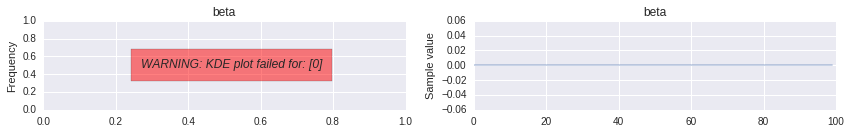

In [70]:
pm.traceplot(trace, vars = ['beta'])